In [1]:
import numpy as np
from random import randint

import string
import re

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


### Szövegbeolvasások

In [2]:
arany = open("arany.txt", "r", encoding = "utf-8").read()
petofi = open("petofi.txt", "r", encoding = "utf-8").read()

In [3]:
def clean_regex(poem):
    lower = poem.lower()
    no_paren = re.sub("[\(\[].*?[\)\]]", '', lower)
    no_digits = no_paren.translate(str.maketrans('', '', string.digits))
    commas = re.sub("[;!?:,.]", '.', no_digits)
    no_triple_dots = re.sub("\.{3}", '.', commas)
    clean = re.sub(' +', ' ', no_triple_dots) # multiple spaces
    return clean

In [4]:
arany_clean = clean_regex(arany)
petofi_clean = clean_regex(petofi)

In [5]:
arany_lista = text_to_word_sequence(arany_clean)
petofi_lista = text_to_word_sequence(petofi_clean)

print('Arany összes szava 1847-49: %d' % len(arany_lista))
print('Arany egyedi szavai 1847-49: %d' % len(set(arany_lista)))

print('\nPetőfi összes szava 1848: %d' % len(petofi_lista))
print('Petőfi egyedi szavai 1848: %d' % len(set(petofi_lista)))

Arany összes szava 1847-49: 3266
Arany egyedi szavai 1847-49: 1767

Petőfi összes szava 1848: 4410
Petőfi egyedi szavai 1848: 2167


### Szólisták tokenizálása (szavak --> számok)

In [6]:
arany_corpus = arany_clean.split(".")
arany_tokenizer = Tokenizer()
arany_tokenizer.fit_on_texts(arany_corpus)

petofi_corpus = petofi_clean.split(".")
petofi_tokenizer = Tokenizer()
petofi_tokenizer.fit_on_texts(petofi_corpus)

### X és y előkészítése tanításhoz

In [7]:
def create_X_y(clean_corpus, tokenizer):
    
    input_sequences = [] 

    for line in clean_corpus:
        token_list = tokenizer.texts_to_sequences([line])[0] 
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1] 
            input_sequences.append(n_gram_sequence) 

    print('Tanító mondatok száma:', len(input_sequences))

    max_length = max([len(x) for x in input_sequences]) 
    padded_seq = np.array(pad_sequences(input_sequences, maxlen = max_length, padding = 'pre')) 
    X, y = padded_seq[:, :-1], padded_seq[: ,-1] 
    y = to_categorical(y, num_classes = len(tokenizer.word_index) + 1)

    return X, y

In [8]:
X_arany, y_arany = create_X_y(arany_corpus, arany_tokenizer)

Tanító mondatok száma: 2409


In [9]:
X_petofi, y_petofi = create_X_y(petofi_corpus, petofi_tokenizer)

Tanító mondatok száma: 3307


In [10]:
print('Arany X és y:')
print('\n', X_arany.shape, y_arany.shape)
print('\n Tanító mondatok:', X_arany.shape[0], '. Kimenetel / következő szó lehetséges értékek:', y_arany.shape[1])
print('\nPetőfi X és y:')
print('\n', X_petofi.shape, y_petofi.shape)
print('\n Tanító mondatok:', X_petofi.shape[0], '. Kimenetel / következő szó lehetséges értékek:', y_petofi.shape[1])

Arany X és y:

 (2409, 15) (2409, 1768)

 Tanító mondatok: 2409 . Kimenetel / következő szó lehetséges értékek: 1768

Petőfi X és y:

 (3307, 16) (3307, 2168)

 Tanító mondatok: 3307 . Kimenetel / következő szó lehetséges értékek: 2168


### Modell építés és tanítás

In [49]:
a = Sequential()

a.add(Embedding(len(arany_tokenizer.word_index) + 1, 64, input_length = X_arany.shape[1]))

a.add(LSTM(256, return_sequences = True))
a.add(Dropout(1/3))
a.add(LSTM(512))
a.add(Dropout(1/3))

a.add(Dense(1024, activation = 'relu'))
a.add(Dense(len(arany_tokenizer.word_index) + 1, activation = 'softmax'))

In [50]:
p = Sequential()

p.add(Embedding(len(petofi_tokenizer.word_index) + 1, 64, input_length = X_petofi.shape[1]))

p.add(LSTM(256, return_sequences = True))
p.add(Dropout(1/3))
p.add(LSTM(512))
p.add(Dropout(1/3))

p.add(Dense(1024, activation = 'relu'))
p.add(Dense(len(petofi_tokenizer.word_index) + 1, activation = 'softmax'))

In [51]:
a.summary(), p.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 15, 64)            113152    
_________________________________________________________________
lstm_17 (LSTM)               (None, 15, 256)           328704    
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 512)               1574912   
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_17 (Dense)             (None, 1768)            

(None, None)

Arany: 1.9 millió paraméter hangolás

Petőfi: 2.2 millió paraméter hangolás

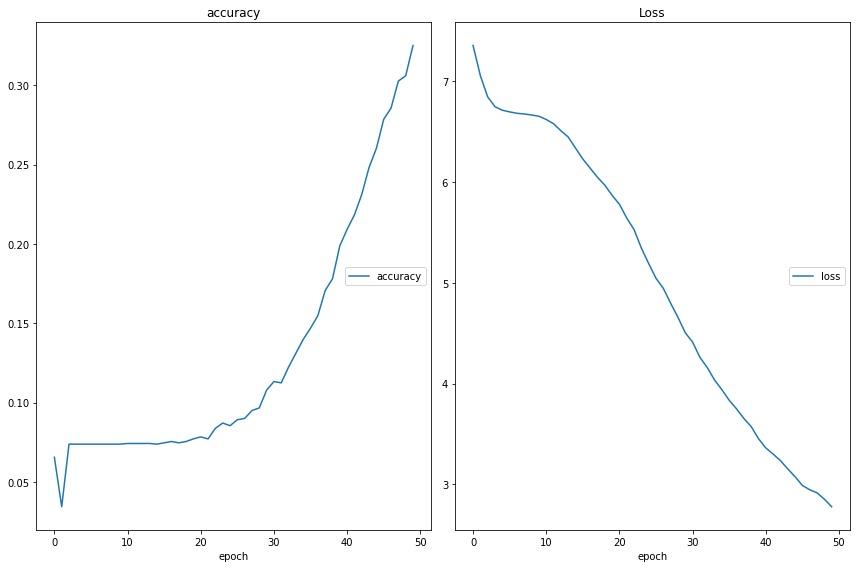

accuracy
	accuracy         	 (min:    0.034, max:    0.325, cur:    0.325)
Loss
	loss             	 (min:    2.779, max:    7.353, cur:    2.779)


In [52]:
a.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
a.fit(X_arany, y_arany, batch_size = 256, epochs = 50, #validation_split = 1/3,
      callbacks = [PlotLossesKeras(), EarlyStopping(monitor = 'loss', patience = 10)])

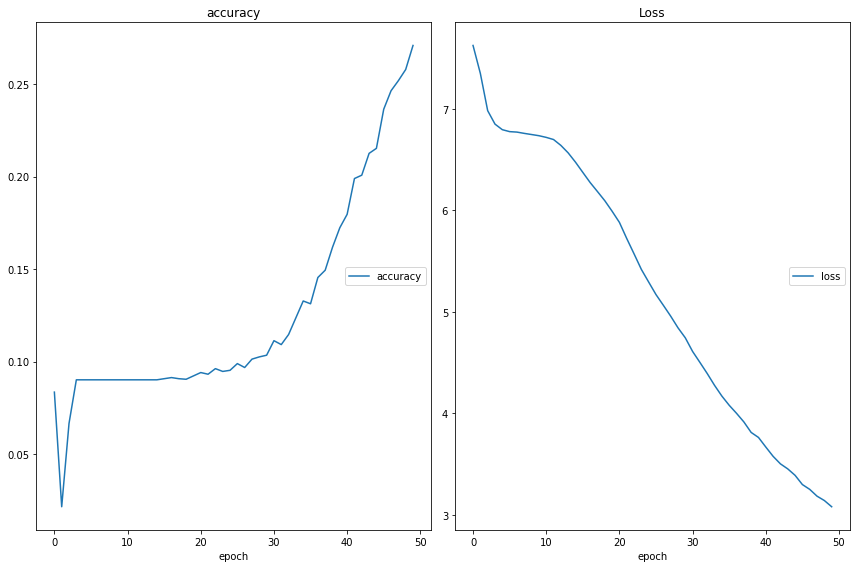

accuracy
	accuracy         	 (min:    0.021, max:    0.271, cur:    0.271)
Loss
	loss             	 (min:    3.079, max:    7.625, cur:    3.079)


In [53]:
p.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
p.fit(X_petofi, y_petofi, batch_size = 256, epochs = 50, #validation_split = 1/3,
      callbacks = [PlotLossesKeras(), EarlyStopping(monitor = 'loss', patience = 10)])

In [37]:
a.save("LSTM_arany_new.h5")
p.save("LSTM_petofi_new.h5")

In [ ]:
a = load_model("LSTM_arany_new.h5")
p = load_model("LSTM_petofi_new.h5")

### Szöveg-generálás

In [38]:
def generate_text(model, tokenizer, seq_length, in_text, n_words):
    
    result = [in_text]
    for i in range(n_words):
        
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen = seq_length, truncating='pre')
        yhat = model.predict_classes(encoded, verbose=0)
          
        out_word = ''
            
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
                
                
        in_text += ' ' + out_word         
        result.append(out_word)
            
    return ' '.join(result)

In [54]:
szoveg = "Ahogy az ősz megérkezett az emberek"

arany_folyt = generate_text(a, arany_tokenizer, X_arany.shape[1], szoveg, 30)
petofi_folyt = generate_text(p, petofi_tokenizer, X_petofi.shape[1], szoveg, 30)

print('Arany mondata:\n', arany_folyt)
print('\nPetőfi mondata:\n', petofi_folyt)

Arany mondata:
 Ahogy az ősz megérkezett az emberek bánja tûzbe zöld költészet arcot halálát ezzel mintegy megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni megszépíteni

Petőfi mondata:
 Ahogy az ősz megérkezett az emberek derekad van bágyadt alakjára festve érezzek bár százszor fájdalmakat fájdalmakat komával komával komával komával ûl ûl szét komor ûl körûl arcára érezzek szomszéddal komával komával komával komával komával komával komával


### Következő szavak valószínűségeinek összevetése

In [42]:
def next_word_probabilities(in_text, model, tokenizer, input, length):
    
    encoded = tokenizer.texts_to_sequences([in_text])[0]
    encoded = pad_sequences([encoded], maxlen = input, truncating = 'pre')
    
    top_n = model.predict(encoded)[0].argsort()[-length:][::-1]

    predicted_words = []
    prediced_probabilities = []

    for n in top_n:

        prediction = tokenizer.index_word[n]
        predicted_words.append(prediction)

        probability = model.predict_proba(encoded)[0][n]
        prediced_probabilities.append(probability)

    return list(zip(predicted_words, prediced_probabilities))

In [55]:
szoveg = "Ahogy az ősz megérkezett az emberek"

print('Arany következő szavak valószínűségek: \n')
print(next_word_probabilities(szoveg, a, arany_tokenizer, 15, 5))
print('\nPetőfi következő szavak valószínűségek: \n')
print(next_word_probabilities(szoveg, p, petofi_tokenizer, 16, 5))

Arany következő szavak valószínűségek: 

[('bánja', 0.47379956), ('tavaszról', 0.32780567), ('beszéd', 0.033863265), ('édes', 0.025481917), ('jobb', 0.022918146)]

Petőfi következő szavak valószínűségek: 

[('derekad', 0.14037676), ('de', 0.09091358), ('ellennek', 0.07610529), ('vegye', 0.046922583), ('enyésznek', 0.04399422)]
